In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Project import Project

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Scripts.neuralnets.NNTrainingUtils import train_autoencoder
from Scripts.neuralnets.NNPreinstalledModelSelection import *
from Scripts.neuralnets.NNTrainingUtils import train, kfold_train
from Scripts.data.SSVEPDataset import SSVEPDataset
from Scripts.data.SSVEPDataloader import SSVEPDataloader

In [4]:
ngpu = 1; device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

***

In [5]:
def read_data(dataframe):
    return torch.tensor(pd.read_csv(dataframe['path'], sep = ' ', header = None, dtype = float).values)

def dataVisualization(X1, X2, save = False, filename = None):
    fig, axs = plt.subplots(nrows = 2, ncols = 1)
    
    fig.set_size_inches(12, 5)
    fig.subplots_adjust(hspace = 0)
    
    for ax in axs:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    
    axs[0].imshow(X1, cmap = 'gray'); axs[0].set_title("Original")
    axs[1].imshow(X2, cmap = 'gray'); axs[1].set_title("Autoencoder's Output")
    
    if save: fig.savefig(filename)
    
    return fig, axs

def EncoderVisualization(model, data, save = False, filename = None):
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(15, 15)
    fig.tight_layout()
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    
    image = model.encode(data).detach()[0]
    image = (image.transpose(0, 2).transpose(0, 1).numpy())
    ax.imshow(image)
    if save: fig.savefig(filename)
        
    return fig, axs

***

In [24]:
preprocessing = 'cca'
signal_length = '512'
data = pd.read_csv((Project.output_dir / ('SSVEPDataset_'+signal_length+'.csv')).__str__(), dtype = 'str')
dataset = SSVEPDataset(Project, preprocessing, data, signal_length)

In [6]:
batch_size = 64
dataloaders, dataset_sizes = SSVEPDataloader(dataset, batch_size)
print(dataset_sizes)

{'train': 2184, 'val': 546}


In [7]:
from Models.Autoencoder1 import Autoencoder

In [33]:
model = Autoencoder(kernel_n = 5, stride = 16).to(device)
summary(model, (1, 16, int(signal_length)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 16, 32]              36
       BatchNorm2d-2            [-1, 3, 16, 32]               6
              ReLU-3            [-1, 3, 16, 32]               0
         MaxPool2d-4  [[-1, 3, 16, 16], [-1, 3, 16, 16]]               0
       MaxUnpool2d-5            [-1, 3, 16, 32]               0
   ConvTranspose2d-6           [-1, 1, 16, 512]              34
Total params: 76
Trainable params: 76
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 4.39
Params size (MB): 0.00
Estimated Total Size (MB): 4.42
----------------------------------------------------------------


In [34]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

In [35]:
model, stats = train_autoencoder(Project, model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs = 100)

[23/Sep/2020 16:13:07] INFO - Epoch    Stage       Loss  

[23/Sep/2020 16:13:08] INFO - 1/100    Training    1.03  
[23/Sep/2020 16:13:08] INFO -          Validation  1.01  
[23/Sep/2020 16:13:08] INFO - 2/100    Training    1.00  
[23/Sep/2020 16:13:08] INFO -          Validation  0.99  
[23/Sep/2020 16:13:09] INFO - 3/100    Training    0.98  
[23/Sep/2020 16:13:09] INFO -          Validation  0.97  
[23/Sep/2020 16:13:09] INFO - 4/100    Training    0.97  
[23/Sep/2020 16:13:09] INFO -          Validation  0.96  
[23/Sep/2020 16:13:10] INFO - 5/100    Training    0.95  
[23/Sep/2020 16:13:10] INFO -          Validation  0.94  
[23/Sep/2020 16:13:10] INFO - 6/100    Training    0.94  
[23/Sep/2020 16:13:10] INFO -          Validation  0.93  
[23/Sep/2020 16:13:10] INFO - 7/100    Training    0.93  
[23/Sep/2020 16:13:11] INFO -          Validation  0.92  
[23/Sep/2020 16:13:11] INFO - 8/100    Training    0.92  
[23/Sep/2020 16:13:11] INFO -          Validation  0.91  
[23/Sep/2020 

***

In [18]:
exemplo = next(iter(dataloaders['train']))[0][0].unsqueeze(0).to(device)

In [19]:
output = model(exemplo).detach()

In [ ]:
fig, ax = dataVisualization(exemplo.squeeze()[:, :100], output.squeeze()[:, :100], save = False, filename = "16x64_comparison.png")

In [ ]:
fig, ax = EncoderVisualization(model, exemplo, save = False, filename = '16x16_encoded.png')

***

In [12]:
class HybridModel(nn.Module):
    def __init__(self, classifier, encoder):
        super(HybridModel, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, x):
        with torch.set_grad_enabled(False):
            x = self.encoder(x)
        
        x = self.classifier(x)
        
        return x

In [13]:
model_type = 'resnet'; model_size = '50'; num_classes = 5; model_name = model_type + model_size
classifier = model_selection(model_name, num_classes)
encoder = model.encoder
hybrid = HybridModel(classifier, encoder).to(device)

In [14]:
optimizer = optim.SGD(hybrid.parameters(), lr = 0.001, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
criterion = nn.CrossEntropyLoss()

In [ ]:
hybrid, stats = kfold_train(Project, hybrid, dataset, criterion, optimizer, num_epochs = 20, num_folds = 5)

***

In [13]:
losses = {}

In [38]:
losses['16x16_train'] = stats['Train'] 
losses['16x16_test']  = stats['Validation']

In [36]:
from matplotlib.lines import Line2D
plt.style.use('seaborn')

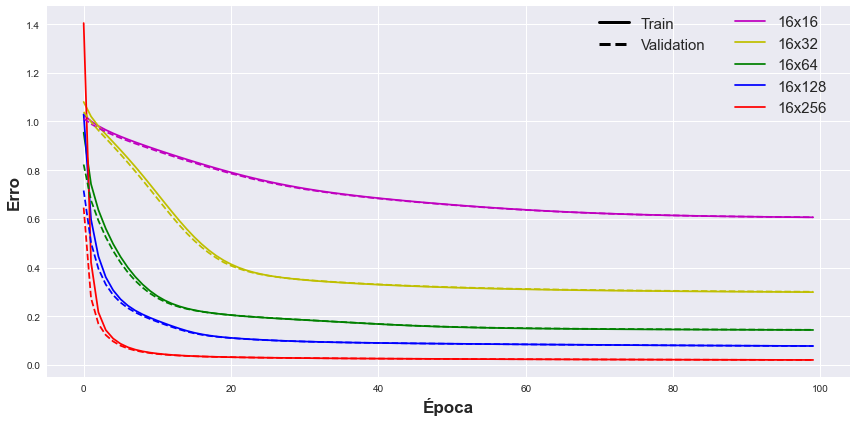

In [48]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(12, 6)

colors = {
    '16':'m',
    '32':'y',
    '64':'g',
    '128':'b',
    '256':'r'
}

sizes = ['16', '32', '64', '128', '256']
# sizes = ['16', '32', '64', '128']
# sizes = ['16', '32', '64']
labels = []
for s in sizes:
    labels.append('16x'+s)
    ax.plot(range(100), losses['16x'+s+'_train'], color = colors[s])

lines = ax.get_lines()
    
for s in sizes:
    ax.plot(range(100), losses['16x'+s+'_test'], linestyle = '--', color = colors[s])
    
    
trainline = Line2D([0], [0], color='k', linewidth=3, linestyle='-')
valline   = Line2D([0], [0], color='k', linewidth=3, linestyle='--')


legend1 = plt.legend(lines, labels, loc = (0.85, 0.69), fontsize = 15)
legend2 = plt.legend([trainline, valline], ['Train', 'Validation'], loc = (0.68, 0.86), fontsize = 15)

plt.xlabel('Época', fontweight='bold', fontsize = 17)
plt.ylabel('Erro', fontweight = 'bold', fontsize = 17)

plt.gca().add_artist(legend1)
fig.tight_layout()
fig.savefig("trainingautoencoder_512.png")